## Sinewave Function

In [1]:
import MCMC_DZ.MCMC.Statistic_tools as Sts
import MCMC_DZ.MCMC.Visualization_tools as Vts
import numpy as np
import matplotlib.pyplot as plt
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
import MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions as PDs

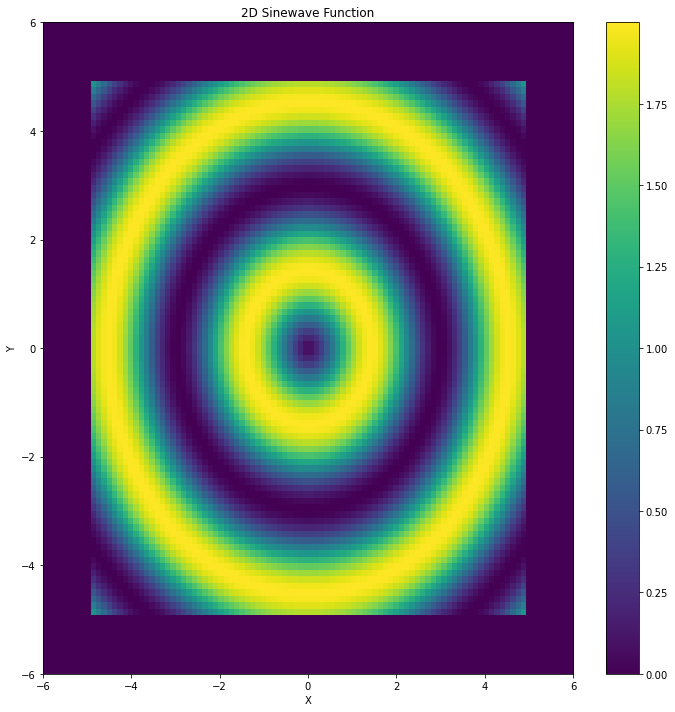

In [2]:
from MCMC_DZ.BayesianInference.Likelihood_functions import Sinewave
SF = Sinewave.Sinewave_function(1, 2, 0.65, [[-5, 5], [-5, 5]])
Vts.Target_Distribution_Visualization(X_range=[-6, 6], Y_range=[-6, 6], Tar_Dis=SF.f, Func_name="2D Sinewave Function", alpha=1)

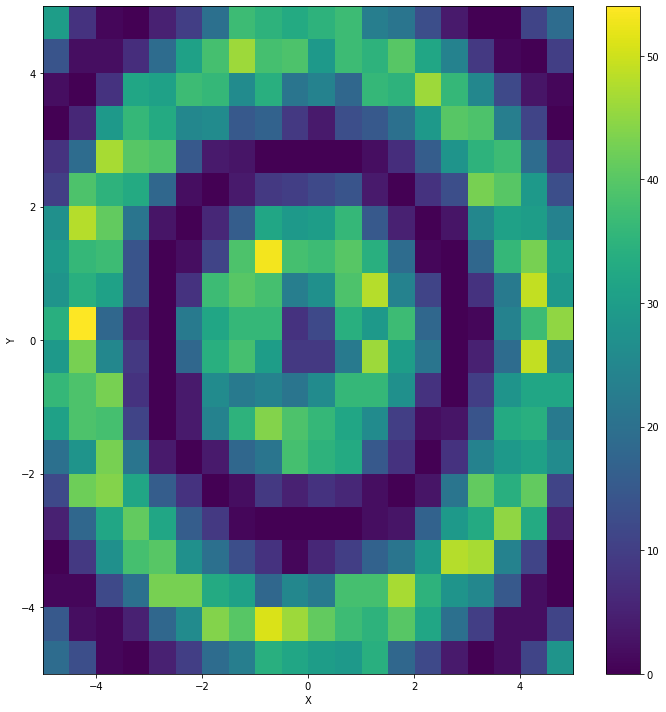

In [3]:
import matplotlib.pyplot as plt

Data_range = np.array([[-5, 5], [-5, 5]])

SFFD_P = Sts.FakeDataGen2D_Poisson(SF.f, [[-5, 5], [-5, 5]], 20, scaler=80)

Vts.PlotHeatmap(SFFD_P.x ,SFFD_P.y, SFFD_P.FakeData.reshape(SFFD_P.x.shape), xlabel="X", ylabel="Y", zlabel="F(X,Y)")

In [4]:
SF_l =  Sinewave.Sinewave_likeli(SFFD_P, 1, Data_range)

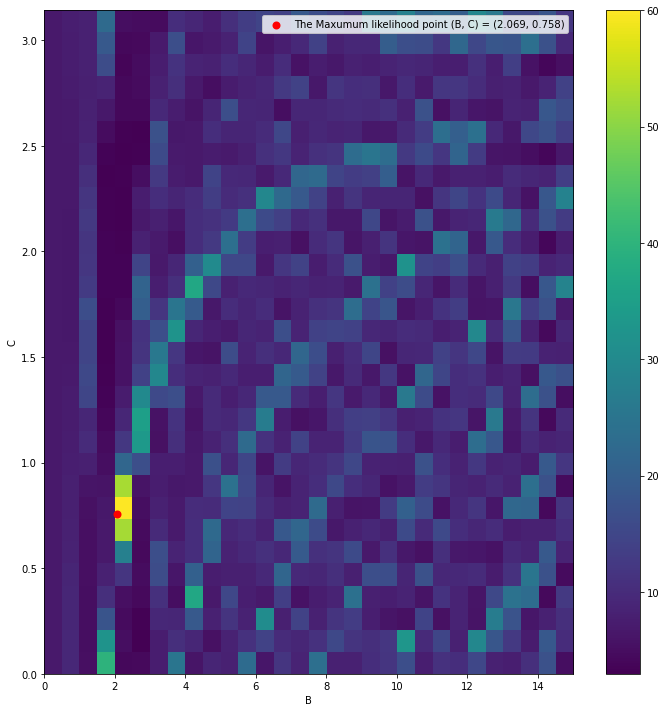

In [5]:
Bs = np.linspace(0, 15, 30)
Cs = np.linspace(0, np.pi, 30)
Bs, Cs = np.meshgrid(Bs, Cs)

Ls = []
for params in zip(Bs.flatten(), Cs.flatten()):
    Ls.append(SF_l.l(params))

Ls = np.asarray(Ls).reshape(Bs.shape)
Vts.PlotHeatmap(Bs, Cs, Ls, xlabel="B", ylabel="C", zlabel="l(A, B)", Plot_Max=True)

In [6]:
from MCMC_DZ.MCMC.MetropolisHastingMCMC.MHMC import MHMC
from MCMC_DZ.MCMC.MetropolisHastingMCMC.ProposalDistributions import  GaussianProposalDistribution, HamiltonianProposalFunction

steps = 100000
Prop_G = GaussianProposalDistribution(sd=0.01, Dim=2)
Prop_H = HamiltonianProposalFunction(rho=SF_l.l, epsilon=0.009, L=5)
MHMC_SF = MHMC(rho=SF_l.l, log_likelihood=False)
Res_G_SF = MHMC_SF.generate(
    theta0=[0 for _ in range(2)], 
    qProb=Prop_G.qProb,
    qSamp=Prop_G.qSample,
    steps=steps,
    OutputRunTime=100,
    MaxTime=60
    )

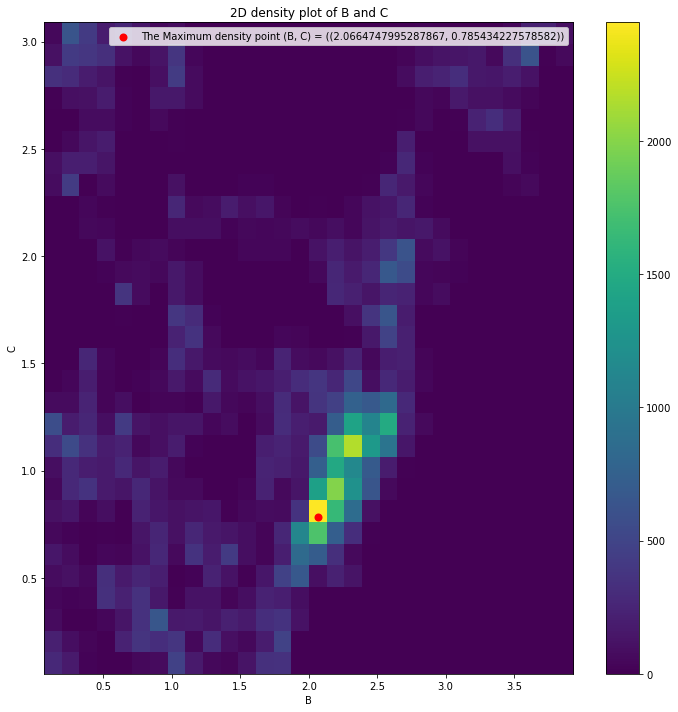

In [7]:
Vts.density_plot(
    Res_G_SF["Thetas"], 
    bins=30,
    burn_in=100,
    credible_region=0,
    x_name="B",
    y_name="C",
    alpha=1
)

/Users/zhangdian/Documents/GitHub/MResMCMC2023/MCMC_DZ/MCMC/Visualization_tools.py:232: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


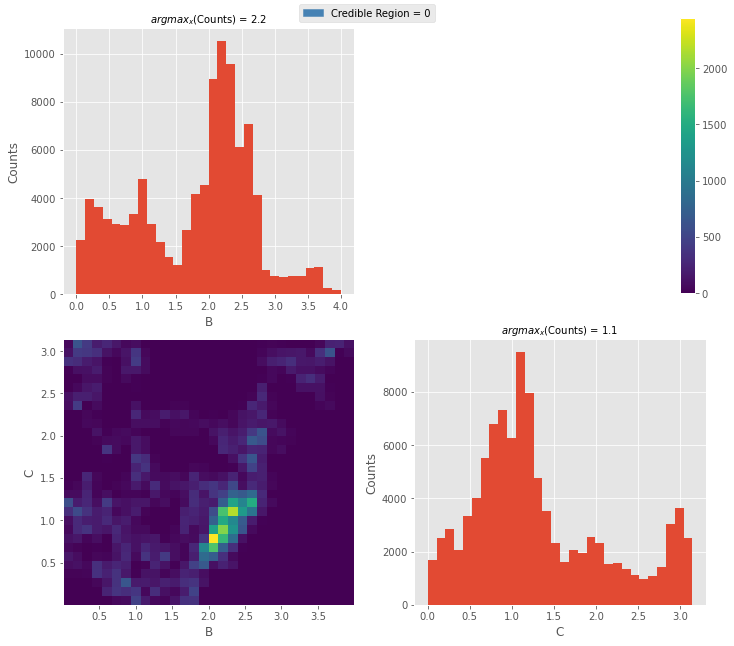

In [8]:
_ = Vts.density_plots(
    Res_G_SF["Thetas"], 
    bins=30,
    burn_in=1000,
    plot_axis=[0, 1],
    axis_name=["B", "C"]
)

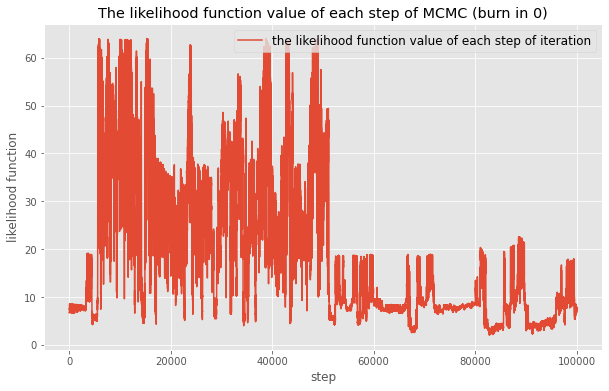

In [22]:
Vts.targetDis_step_plot(Thetas=Res_G_SF["Thetas"], rho=SF_l.l, target_type="likelihood function", burn_in=0, figsize=(10,6))

### Testing Functions

In [9]:
def density_ratioplot_3D(Thetas, rho, bins, x_axis=0, y_axis=1, x_name="x", y_name="y", burn_in=0, alpha=1, label="", Save_fig=False, fig_name="3D density plot", Plot3D=False):
    """
    Plot an interactive 3D heatmap of a pair of dimensions from the input data.

    Arguments:
    Thetas (np.array): the value of parameters generated by the MCMC model
    bins (int): the number of bins of each histogram and heat map
    x_axis (int): the index of the x-axis to plot
    y_axis (int): the index of the y-axis to plot
    x_name (string): the name of the x-axis to plot
    y_name (string): the name of the y-axis to plot
    burn_in (int): the number of the data points want to "burn_in" for the graph
    credible_region (float): the size of the credible region in percent
    figsize (tuple): the size of the figure
    label (string): the label want to add to the plot
    Save_fig (bool): decide whether to save the output figure of the function
    fig_name (string): the saved figure name

    Returns:
    None
    """
    Thetas = np.asarray(Thetas)

    # prepare the data for the 2D histogram
    hist, xedges, yedges = np.histogram2d(Thetas[burn_in:, x_axis], Thetas[burn_in:, y_axis], bins=bins)
    xmid = 0.5*(xedges[1:] + xedges[:-1])
    ymid = 0.5*(yedges[1:] + yedges[:-1])
    X, Y = np.meshgrid(xmid, ymid)

    Likeli = np.asarray([rho(np.asarray([x,y])) for (x,y) in zip(X.flatten(), Y.flatten())])
    Likeli = Likeli.reshape(X.shape)
    Likeli = (Likeli - np.min(Likeli)) / np.sum(Likeli - np.min(Likeli))
    hist = (hist.T - np.min(hist)) / np.sum(hist - np.min(hist))
    # Calculate the Z axis value of the heat map
    Z = ((Likeli + 1e-10) / (hist + 1e-10))

    if Plot3D:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        # plot the density
        # plot the density plot of the inputted data
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=alpha)
        # # Add contour plots
        # cset = ax.contour(X, Y, hist.T, zdir='z', offset=np.min(hist), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='x', offset=np.min(xedges), cmap=plt.cm.coolwarm)
        # cset = ax.contour(X, Y, hist.T, zdir='y', offset=np.max(yedges), cmap=plt.cm.coolwarm)

        fig.colorbar(ax.plot_surface(X, Y, Z, cmap='viridis'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"3D ratio plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.set_zlabel("ratio")
        ax.set_box_aspect([1, 1, 0.7])
        # ax.view_init(elev=-1.7, azim=-1.7)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()
    else:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        # plot the density plot of the inputted data
        ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto')

        fig.colorbar(ax.imshow(Z, cmap='viridis', origin='lower', alpha=alpha, extent=[X.min(), X.max(), Y.min(), Y.max()], aspect='auto'))
        # create 3D heatmap with the data prepared above
        ax.set_title(f"2D difference plot of true value and approximation of {x_name} and {y_name}"+label)

        ax.set_xlabel(x_name)
        ax.set_ylabel(y_name)
        ax.dist = 10

        plt.tight_layout()
        if (Save_fig): 
            plt.savefig(fig_name+".png")
        plt.show()

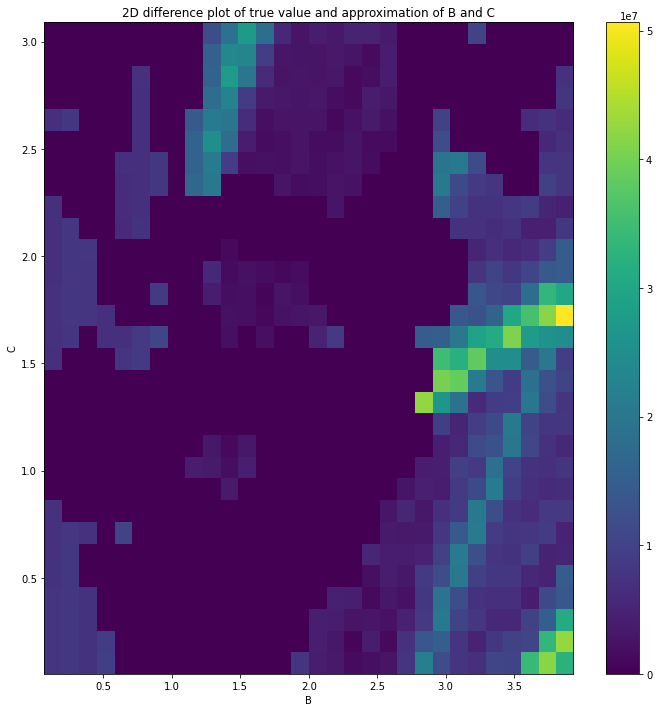

In [10]:
density_ratioplot_3D(
    Res_G_SF["Thetas"], 
    rho=SF_l.l,
    bins=30,
    burn_in=2000,
    x_name="B",
    y_name="C",
    alpha=1
)